In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import numpy as np

In [2]:
import torch
import joblib
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
from Hueristic_methods.Heuristic_Method import hueristic_Method 

In [4]:
# Load the dataset
train_file_path = "./datasets/Train_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
train_data = pd.read_csv(train_file_path)

test_file_path = "./datasets/Test_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
test_data = pd.read_csv(test_file_path)

In [5]:
# print(f"Length of train data: {len(train_data)}")
# print(f"Length of test data: {len(raw_data)}")


In [6]:
# #Define levels
# levels=5

# # Parse relevant columns for all bid and ask levels
# bid_columns = [f"bids[{i}].price" for i in range(levels)] + [f"bids[{i}].amount" for i in range(levels)]
# ask_columns = [f"asks[{i}].price" for i in range(levels)] + [f"asks[{i}].amount" for i in range(levels)]
# feature_columns = bid_columns  + ask_columns 
# target_columns=['next_1st_mark_price']
# eval_columns=target_columns+ ["mark_price",'1st_Price_Movement',"1st_actual_direction"]

# # Features and target
# X_train_heuristic = train_data[feature_columns+['mark_price']]
# X_train = train_data[feature_columns]
# y_train = train_data['next_1st_mark_price']

# X_test_heuristic = test_data[feature_columns+['mark_price']]
# X_test = test_data[feature_columns]
# y_test = test_data[eval_columns]

In [7]:
file_path = "./datasets/Test_Pre_Processed_Dataset.csv"
raw_data = pd.read_csv(file_path)

# Define bid/ask columns and feature columns
levels = 5
bid_price_cols = [f"bids[{i}].price" for i in range(levels)]
ask_price_cols = [f"asks[{i}].price" for i in range(levels)]
feature_columns = bid_price_cols + ask_price_cols

raw_data_lstm=raw_data.copy()
raw_data_lstm["target"] = raw_data_lstm["mark_price"].shift(-1)
raw_data_lstm.dropna(inplace=True)

raw_data_lstm["mid_price"] = (raw_data_lstm[bid_price_cols[0]] + raw_data_lstm[ask_price_cols[0]]) / 2

scaler_X = StandardScaler()
scaler_y = StandardScaler()
raw_data_lstm[feature_columns] = scaler_X.fit_transform(raw_data_lstm[feature_columns])
raw_data_lstm["target"] = scaler_y.fit_transform(raw_data_lstm[["target"]])
raw_data_lstm["mid_price"] = scaler_y.fit_transform(raw_data_lstm[["mid_price"]])

# Compute mid_price and ensure numeric types
raw_data["mid_price"] = (raw_data[bid_price_cols[0]] + raw_data[ask_price_cols[0]]) / 2
raw_data[feature_columns] = raw_data[feature_columns].astype(float)
raw_data["mark_price"] = raw_data["mark_price"].astype(float)

# --- Compute VWAP_bid, VWAP_ask, and spread for the heuristic method ---
# Note: This assumes that for each row, the bid and ask amount columns exist.
# You may need to adjust if your CSV has separate columns for amounts.
raw_data["VWAP_bid"] = sum(raw_data[f"bids[{i}].price"] * raw_data[f"bids[{i}].amount"] for i in range(levels)) / \
                        sum(raw_data[f"bids[{i}].amount"] for i in range(levels))
raw_data["VWAP_ask"] = sum(raw_data[f"asks[{i}].price"] * raw_data[f"asks[{i}].amount"] for i in range(levels)) / \
                        sum(raw_data[f"asks[{i}].amount"] for i in range(levels))
raw_data["spread"] = raw_data["VWAP_ask"] - raw_data["VWAP_bid"]

# For simulation purposes, we use the entire dataset.
eval_data_ml = raw_data.reset_index(drop=True)

# only for lr_2lebels
bid_cols_full = [f"bids[{i}].price"  for i in range(levels)] + \
                [f"bids[{i}].amount" for i in range(levels)]
ask_cols_full = [f"asks[{i}].price"  for i in range(levels)] + \
                [f"asks[{i}].amount" for i in range(levels)]
feature_cols_full = bid_cols_full + ask_cols_full

In [8]:
adaboost_model = joblib.load("ML/adaboost_model.pkl", mmap_mode=None)
GB_model = joblib.load("ML/GB_model.pkl", mmap_mode=None)
lr_model = joblib.load("ML/lr_model.pkl", mmap_mode=None)
svr_model = joblib.load("ML/svr_model.pkl", mmap_mode=None)
lr2_model = joblib.load("ML/lr_two_label.pkl")

In [9]:
heuristic_model = hueristic_Method(raw_data.copy(), raw_data.copy(), levels)

In [10]:
data_nn = raw_data_lstm.copy()
scaler_X = StandardScaler()
data_nn[feature_columns] = scaler_X.fit_transform(data_nn[feature_columns].astype(float))
scaler_target = StandardScaler()
data_nn["mark_price_scaled"] = scaler_target.fit_transform(data_nn[["mark_price"]])
scaler_mid = StandardScaler()
data_nn["mid_price_scaled"] = scaler_mid.fit_transform(data_nn[["mid_price"]])

# Use the entire dataset for NN simulation.
eval_data_nn = data_nn.reset_index(drop=True)

# Define NN input size and hidden state size.
input_size_combined = len(feature_columns) + 1
hidden_size = 64

In [11]:
class HFTDatasetCombined(Dataset):
    def __init__(self, df, feature_cols, guarantor_col, target_col):
        self.X_features = df[feature_cols].values.astype(np.float32)
        self.guarantor = df[guarantor_col].values.astype(np.float32).reshape(-1, 1)
        self.X = np.concatenate([self.X_features, self.guarantor], axis=1)
        self.y = df[target_col].values.astype(np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

In [12]:
test_dataset = HFTDatasetCombined(raw_data_lstm, feature_columns, "mid_price", "target")

In [13]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [14]:

# -------------------------------
# Define the Standard LSTM Model
# -------------------------------
class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[-1]
        out = self.fc(out)
        return out

# -------------------------------
# Define the OPTM-LSTM Model and Cell
# -------------------------------
class OPTMLSTMCellTorch(nn.Module):
    def __init__(self, input_dim, hidden_size, gd_iters=7, gd_lr=0.0001):
        super(OPTMLSTMCellTorch, self).__init__()
        self.hidden_size = hidden_size
        self.gd_iters = gd_iters
        self.gd_lr = gd_lr
        self.linear = nn.Linear(input_dim, 4 * hidden_size, bias=True)
        self.recurrent_linear = nn.Linear(hidden_size, 4 * hidden_size, bias=False)
        self.sigmoid = torch.sigmoid
        self.tanh = torch.tanh

    def forward(self, x, h, c):
        x_features = x[:, :-1]
        guarantor = x[:, -1].view(-1, 1)
        
        z = self.linear(x_features) + self.recurrent_linear(h)
        z_i, z_f, z_c, z_o = z.chunk(4, dim=1)
        i = self.sigmoid(z_i)
        f = self.sigmoid(z_f)
        c_t = self.tanh(z_c)
        o = self.sigmoid(z_o)
        c_new = f * c + i * c_t
        h_temp = o * self.tanh(c_new)
        
        gated_vector = torch.cat([i, f, c_t, c_new, o, h_temp], dim=1)
        theta = torch.ones(6 * self.hidden_size, 1, device=x.device)
        for _ in range(self.gd_iters):
            y_pred = gated_vector @ theta
            error = y_pred - guarantor
            grad = (2 / x.size(0)) * (gated_vector.t() @ error)
            theta = theta - self.gd_lr * grad

        theta_parts = torch.chunk(theta, 6, dim=0)
        importance = [torch.mean(torch.abs(part)) for part in theta_parts]
        importance_stack = torch.stack(importance)
        max_idx = torch.argmax(importance_stack)

        if max_idx.item() == 0:
            new_h = i
        elif max_idx.item() == 1:
            new_h = f
        elif max_idx.item() == 2:
            new_h = c_t
        elif max_idx.item() == 3:
            new_h = c_new
        elif max_idx.item() == 4:
            new_h = o
        else:
            new_h = h_temp
        
        return new_h, c_new

class OPTMLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(OPTMLSTM, self).__init__()
        self.hidden_size = hidden_size
        # Note: the cell input dim is input_size - 1 because the last feature is the guarantor.
        self.cell = OPTMLSTMCellTorch(input_dim=input_size - 1, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        seq_len, batch, _ = x.shape
        device = x.device
        h = torch.zeros(batch, self.hidden_size, device=device)
        c = torch.zeros(batch, self.hidden_size, device=device)
        for t in range(seq_len):
            x_t = x[t]
            h, c = self.cell(x_t, h, c)
        out = self.fc(h)
        return out



In [15]:
# Create NN model instances and load weights.
model_lstm = StandardLSTM(input_size_combined, hidden_size)
model_optm = OPTMLSTM(input_size_combined, hidden_size)
model_lstm.load_state_dict(torch.load("standard_lstm_weights.pth", map_location="cpu"))
model_optm.load_state_dict(torch.load("optmlstm_weights.pth", map_location="cpu"))
# Move NN models to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm.to(device)
model_optm.to(device)
model_lstm.eval()
model_optm.eval()

OPTMLSTM(
  (cell): OPTMLSTMCellTorch(
    (linear): Linear(in_features=10, out_features=256, bias=True)
    (recurrent_linear): Linear(in_features=64, out_features=256, bias=False)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
def evaluate_model_with_preds(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    preds = []
    actuals = []
    infer_times = []
    criterion = nn.MSELoss()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.unsqueeze(0).to(device)
            y = y.view(-1, 1).to(device)
            start = time.time()
            output = model(x)
            end = time.time()
            infer_times.append((end - start) / x.size(1))
            loss = criterion(output, y)
            total_loss += loss.item() * x.size(1)
            preds.append(output.cpu().numpy())
            actuals.append(y.cpu().numpy())
    preds = np.vstack(preds)
    actuals = np.vstack(actuals)
    mse = total_loss / len(loader.dataset)
    avg_infer_time = np.mean(infer_times)
    metrics = {"MSE": mse, "Average Inference Time per Sample (s)": avg_infer_time}
    return metrics, preds, actuals

def compute_accuracy_metrics(preds, actuals, tol_factor=0.0001):
    preds_flat = preds.flatten()
    actuals_flat = actuals.flatten()
    mse = np.mean((preds_flat - actuals_flat) ** 2)
    
    actual_diff = np.sign(np.diff(actuals_flat, prepend=actuals_flat[0]))
    pred_diff = np.sign(np.diff(preds_flat, prepend=preds_flat[0]))
    directional_accuracy = np.mean(actual_diff == pred_diff)
    
    tol = tol_factor * np.mean(np.abs(actuals_flat))
    tolerance_accuracy = np.mean(np.abs(preds_flat - actuals_flat) <= tol)
    
    return {"MSE": mse,
            "Directional Accuracy": directional_accuracy,
            "Tolerance Accuracy": tolerance_accuracy}

In [17]:
metrics_lstm_test, preds_lstm_test, actuals_lstm_test = evaluate_model_with_preds(model_lstm, test_loader)
metrics_optm_test, preds_optm_test, actuals_optm_test = evaluate_model_with_preds(model_optm, test_loader)

print("\nStandard LSTM Test Metrics:")
for k, v in metrics_lstm_test.items():
    print(f"{k}: {v}")
print("\nOPTM-LSTM Test Metrics:")
for k, v in metrics_optm_test.items():
    print(f"{k}: {v}")

acc_metrics_lstm = compute_accuracy_metrics(preds_lstm_test, actuals_lstm_test)
acc_metrics_optm = compute_accuracy_metrics(preds_optm_test, actuals_optm_test)

print("\nStandard LSTM Accuracy Metrics:")
for k, v in acc_metrics_lstm.items():
    print(f"{k}: {v}")
print("\nOPTM-LSTM Accuracy Metrics:")
for k, v in acc_metrics_optm.items():
    print(f"{k}: {v}")



Standard LSTM Test Metrics:
MSE: 0.0003248178533403723
Average Inference Time per Sample (s): 6.940217457302011e-05

OPTM-LSTM Test Metrics:
MSE: 0.0287800609847841
Average Inference Time per Sample (s): 0.00022405592876148037

Standard LSTM Accuracy Metrics:
MSE: 0.0003248178691137582
Directional Accuracy: 0.35818246703768364
Tolerance Accuracy: 0.004118481081028945

OPTM-LSTM Accuracy Metrics:
MSE: 0.02878006175160408
Directional Accuracy: 0.3581535315734141
Tolerance Accuracy: 0.004996190163871179


In [18]:
# Heuristic_Method Predict 
# Measure the execution time of the function
Heuristic_start_time = time.time()
Heuristic_Predict_data=heuristic_model.predict()
Heuristic_end_time = time.time()
execution_time_heuristic = (Heuristic_end_time - Heuristic_start_time)* 1000  /len(test_data)
print(f"Execution_time per sample(Heuristic_Method): {execution_time_heuristic:.10f} milliseconds")

# Linear Regression Predict 
# Measure the execution time of the function
linear_regression_start_time = time.time()
result_lr=lr_model.predict(raw_data[feature_columns])
linear_regression_end_time = time.time()
execution_time_lr = (linear_regression_end_time - linear_regression_start_time)* 1000  /len(test_data)
print(f"Execution_time per sample(Linear Regression): {execution_time_lr:.10f} milliseconds")

# Adaboost Predict 
# Measure the execution time of the function
adaboost_start_time = time.time()
result_adaboost=adaboost_model.predict(raw_data[feature_columns])
adaboost_end_time = time.time()
execution_time_adaboost = (adaboost_end_time - adaboost_start_time)* 1000  /len(test_data)
print(f"Execution_time per sample(adaboost): {execution_time_adaboost:.10f} milliseconds")

# SVR Predict 
# Measure the execution time of the function
SVR_start_time = time.time()
result_svr=svr_model.predict(raw_data[feature_columns])
SVR_end_time = time.time()
execution_time_SVR = (SVR_end_time-SVR_start_time)* 1000 /len(test_data)
print(f"Execution_time per sample(SVR): {execution_time_SVR:.10f} milliseconds")

# Gradient Boosting Predict 
# Measure the execution time of the function
GB_start_time = time.time()
result_GB=GB_model.predict(raw_data[feature_columns])
GB_end_time = time.time()
execution_time_GB = (GB_end_time - GB_start_time)* 1000  /len(test_data)
print(f"Execution_time per sample(Gradient Boosting): {execution_time_adaboost:.10f} milliseconds")






Execution_time per sample(Heuristic_Method): 0.1606132513 milliseconds
Execution_time per sample(Linear Regression): 0.0003931331 milliseconds
Execution_time per sample(adaboost): 0.0029651586 milliseconds
Execution_time per sample(SVR): -21.6613951680 milliseconds
Execution_time per sample(Gradient Boosting): 0.0029651586 milliseconds


In [43]:
execution_time_SVR = (SVR_end_time-SVR_start_time)* 1000 /len(test_data)
execution_time_GB = (GB_end_time - GB_start_time)* 1000  /len(test_data)

In [21]:
eval_np_array= np.array(raw_data[['next_1st_mark_price',"1st_actual_direction"]])

In [53]:
# time
execution_time_lstm=metrics_lstm_test.get("Average Inference Time per Sample (s)")
mse_lstm=acc_metrics_lstm.get("MSE")
directional_accuracy_lstm=acc_metrics_lstm.get("Directional Accuracy")
tolerance_accuracy_lstm=1-acc_metrics_lstm.get("Tolerance Accuracy")

In [54]:
# time
execution_time_optm=metrics_optm_test.get("Average Inference Time per Sample (s)")
mse_optm=acc_metrics_optm.get("MSE")
directional_accuracy_optm=acc_metrics_optm.get("Directional Accuracy")
tolerance_accuracy_optm=1-acc_metrics_optm.get("Tolerance Accuracy")


In [55]:
print(f"Execution_time per sample(Heuristic_Method): {execution_time_heuristic:.10f} milliseconds")
print(f"Execution_time per sample(Linear Regression): {execution_time_lr:.10f} milliseconds")
print(f"Execution_time per sample(adaboost): {execution_time_adaboost:.10f} milliseconds")
print(f"Execution_time per sample(SVR): {execution_time_SVR:.10f} milliseconds")
print(f"Execution_time per sample(Gradient Boosting): {execution_time_GB:.10f} milliseconds")
print(f"Execution_time per sample(LSTM): {execution_time_lstm:.10f} milliseconds")
print(f"Execution_time per sample(OPIM): {execution_time_optm:.10f} milliseconds")



Execution_time per sample(Heuristic_Method): 0.1606132513 milliseconds
Execution_time per sample(Linear Regression): 0.0003931331 milliseconds
Execution_time per sample(adaboost): 0.0029651586 milliseconds
Execution_time per sample(SVR): 21.6613951680 milliseconds
Execution_time per sample(Gradient Boosting): 0.0009706796 milliseconds
Execution_time per sample(LSTM): 0.0000694022 milliseconds
Execution_time per sample(OPIM): 0.0002240559 milliseconds


In [22]:
from help_function import cal_mean_squared_error
from help_function import cal_directional_accuracy
from help_function import cal_Tolerance_Based_accuracy

In [75]:
# Evaluate performance using MSE on evaluation set
mse_heuristic = cal_mean_squared_error(raw_data["next_1st_mark_price"], Heuristic_Predict_data["predicted_heuristic"])
print(f"MSE (Heuristic_Method): {mse_heuristic[0]}")

mse_lr = cal_mean_squared_error(eval_np_array[:,0], result_lr)
print(f"MSE (Linear Regression): {mse_lr[0]}")

mse_adaboost = cal_mean_squared_error(eval_np_array[:,0], result_adaboost)
print(f"MSE (Adaboost): {mse_adaboost[0]}")

mse_svr = cal_mean_squared_error(eval_np_array[:,0], result_svr)
print(f"MSE (SVR): {mse_svr[0]}")

mse_GB = cal_mean_squared_error(eval_np_array[:,0], result_GB)
print(f"MSE (Gradient Boosting): {mse_GB[0]}")

print(f"MSE (LSTM): {mse_lstm}")
print(f"MSE (OPIM): {mse_optm}")


MSE (Heuristic_Method): 3.0971960511530088
MSE (Linear Regression): 13.569991093193208
MSE (Adaboost): 353.08180705421915
MSE (SVR): 13.718234988996533
MSE (Gradient Boosting): 22.56034520716262
MSE (LSTM): 0.0003248178691137582
MSE (OPIM): 0.02878006175160408


In [57]:
# Evaluate performance using MSE on evaluation set
directional_accuracy_heuristic = (raw_data["1st_actual_direction"] == Heuristic_Predict_data["predicted_direction_heuristic"]).mean()
print(f"Directional Accuracy (Heuristic_Method): {directional_accuracy_heuristic:.2%}")

result_sign_lr = np.sign(result_lr - eval_np_array[:,0])
directional_accuracy_lr=cal_directional_accuracy(eval_np_array[:,1],result_sign_lr)
print(f"Directional Accuracy (Linear Regression): {directional_accuracy_lr[0]:.2%}")

result_sign_adaboost = np.sign(result_adaboost - eval_np_array[:,0])
directional_accuracy_adaboost=cal_directional_accuracy(eval_np_array[:,1],result_sign_adaboost)
print(f"Directional Accuracy (AdaBoost): {directional_accuracy_adaboost[0]:.2%}")

# Calculate directional accuracy
result_sign_svr = np.sign(result_svr - eval_np_array[:,0])
directional_accuracy_svr=cal_directional_accuracy(eval_np_array[:,1],result_sign_svr)
print(f"Directional Accuracy (SVR): {directional_accuracy_svr[0]:.2%}")

result_sign_GB = np.sign(result_GB - eval_np_array[:,0])
directional_accuracy_GB=cal_directional_accuracy(eval_np_array[:,1],result_sign_GB)
print(f"Directional Accuracy (Gradient Boosting): {directional_accuracy_GB[0]:.2%}")

print(f"Directional Accuracy (LSTM): {directional_accuracy_lstm:.2%}")

print(f"Directional Accuracy (OPIM): {directional_accuracy_optm:.2%}")


Directional Accuracy (Heuristic_Method): 45.28%
Directional Accuracy (Linear Regression): 28.46%
Directional Accuracy (AdaBoost): 21.53%
Directional Accuracy (SVR): 28.36%
Directional Accuracy (Gradient Boosting): 25.65%
Directional Accuracy (LSTM): 35.82%
Directional Accuracy (OPIM): 35.82%


In [58]:
# Tolerance-Based Accuracy
tolerance = 0.0001 * raw_data["next_1st_mark_price"].mean()  # Set tolerance to 0.01% of average price
raw_data.loc[:, "tolerance_heuristic"] = abs(Heuristic_Predict_data["predicted_heuristic"] - raw_data["next_1st_mark_price"]) <= tolerance

# Calculate tolerance-based accuracy
tolerance_accuracy_heuristic = raw_data["tolerance_heuristic"].mean()
print(f"Tolerance-Based Accuracy (Heuristic_Method): {tolerance_accuracy_heuristic:.2%}")


tolerance_accuracy_lr  = cal_Tolerance_Based_accuracy(eval_np_array[:,0], result_lr)
print(f"Tolerance-Based Accuracy (Linear Regression): {tolerance_accuracy_lr[0]:.2%}")

tolerance_accuracy_adaboost = cal_Tolerance_Based_accuracy(eval_np_array[:,0], result_adaboost)
print(f"Tolerance-Based Accuracy (AdaBoost): {tolerance_accuracy_adaboost[0]:.2%}")

tolerance_accuracy_svr  = cal_Tolerance_Based_accuracy(eval_np_array[:,0], result_svr)
print(f"Tolerance-Based Accuracy (SVR): {tolerance_accuracy_svr[0]:.2%}")


tolerance_accuracy_GB  = cal_Tolerance_Based_accuracy(eval_np_array[:,0], result_GB)
print(f"Tolerance-Based Accuracy (Gradient Boosting): {tolerance_accuracy_GB[0]:.2%}")

print(f"Tolerance-Based Accuracy (LSTM): {tolerance_accuracy_lstm:.2%}")
print(f"Tolerance-Based Accuracy (OPTM): {tolerance_accuracy_optm:.2%}")



Tolerance-Based Accuracy (Heuristic_Method): 99.16%
Tolerance-Based Accuracy (Linear Regression): 90.51%
Tolerance-Based Accuracy (AdaBoost): 20.81%
Tolerance-Based Accuracy (SVR): 90.30%
Tolerance-Based Accuracy (Gradient Boosting): 80.57%
Tolerance-Based Accuracy (LSTM): 99.59%
Tolerance-Based Accuracy (OPTM): 99.50%


In [9]:
# # Evaluate performance (Mean Squared Error) based on mark price
# mse_heuristic = mean_squared_error(Evaluate_result["next_mark_price"], Evaluate_result["predicted_heuristic"])
# print(f"Heuristic Methods MSE (Eval Set): {mse_heuristic:.2f}")

# # Evaluate performance using MSE on evaluation set
# mse_lr = mean_squared_error(Evaluate_result['next_mark_price'], Evaluate_result['predicted_lr'])
# print(f"Linear Regression MSE (Eval Set): {mse_lr:.2f}")

# # Evaluate performance using MSE on evaluation set
# mse_adaboost = mean_squared_error(Evaluate_result['next_mark_price'], Evaluate_result['predicted_adaboost'])
# print(f"AdaBoost MSE (Eval Set): {mse_adaboost:.2f}")

Heuristic Methods MSE (Eval Set): 6.07
Linear Regression MSE (Eval Set): 25.41
AdaBoost MSE (Eval Set): 1118.87


In [10]:
# # Calculate directional accuracy
# directional_accuracy_heuristic = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_heuristic"]).mean()
# print(f"Directional Accuracy (heuristic): {directional_accuracy_heuristic:.2%}")

# # Calculate directional accuracy
# Evaluate_result.loc[:, "predicted_direction_lr"] = np.sign(Evaluate_result["predicted_lr"] - Evaluate_result["next_mark_price"])
# directional_accuracy_lr = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_lr"]).mean()
# print(f"Directional Accuracy (Linear Regression): {directional_accuracy_lr:.2%}")

# # Calculate directional accuracy
# Evaluate_result.loc[:, "predicted_direction_adaboost"] = np.sign(Evaluate_result["predicted_adaboost"] - Evaluate_result["next_mark_price"])
# directional_accuracy_adaboost = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_adaboost"]).mean()
# print(f"Directional Accuracy (AdaBoost): {directional_accuracy_adaboost:.2%}")

Directional Accuracy (heuristic): 36.41%
Directional Accuracy (Linear Regression): 29.83%
Directional Accuracy (AdaBoost): 23.47%


In [11]:
# # Tolerance-Based Accuracy
# tolerance = 0.0001 * Evaluate_result["next_mark_price"].mean()  # Set tolerance to 0.01% of average price

# # Calculate tolerance-based accuracy
# Evaluate_result.loc[:, "tolerance_heuristic"] = abs(Evaluate_result["predicted_heuristic"] - Evaluate_result["next_mark_price"]) <= tolerance
# tolerance_accuracy_heuristic = Evaluate_result["tolerance_heuristic"].mean()
# print(f"Tolerance-Based Accuracy (heuristic): {tolerance_accuracy_heuristic:.2%}")

# # Calculate tolerance-based accuracy
# Evaluate_result.loc[:, "tolerance_lr"] = abs(Evaluate_result["predicted_lr"] - Evaluate_result["next_mark_price"]) <= tolerance
# tolerance_accuracy_lr = Evaluate_result["tolerance_lr"].mean()
# print(f"Tolerance-Based Accuracy (Linear Regression): {tolerance_accuracy_lr:.2%}")

# # Calculate tolerance-based accuracy
# Evaluate_result.loc[:, "tolerance_adaboost"] = abs(Evaluate_result["predicted_adaboost"] - Evaluate_result["next_mark_price"]) <= tolerance
# tolerance_accuracy_adaboost = Evaluate_result["tolerance_adaboost"].mean()
# print(f"Tolerance-Based Accuracy (AdaBoost): {tolerance_accuracy_adaboost:.2%}")

Tolerance-Based Accuracy (heuristic): 97.25%
Tolerance-Based Accuracy (Linear Regression): 80.95%
Tolerance-Based Accuracy (AdaBoost): 18.25%


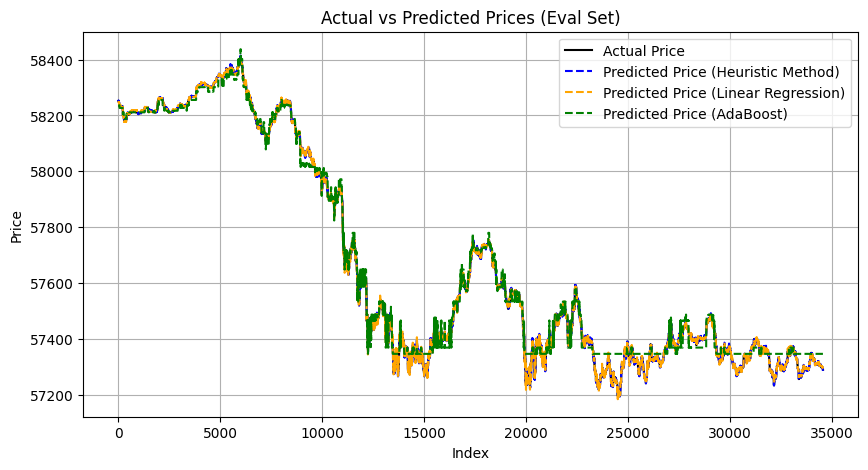

In [12]:
# # Plot actual vs predicted prices
# # Report Size
# # plt.figure(figsize=(12, 6))

# # Poster size
# plt.figure(figsize=(10, 5))

# # Actual
# plt.plot(Evaluate_result.index, Evaluate_result["next_mark_price"], label="Actual Price", color="black")

# # Predicted prices
# plt.plot(Evaluate_result.index,Evaluate_result["predicted_heuristic"], label="Predicted Price (Heuristic Method)", color="blue", linestyle="--")
# plt.plot(Evaluate_result.index, Evaluate_result["predicted_lr"], label="Predicted Price (Linear Regression)", color="orange", linestyle="--")
# plt.plot(Evaluate_result.index, Evaluate_result["predicted_adaboost"], label="Predicted Price (AdaBoost)", color="green", linestyle="--")


# plt.title("Actual vs Predicted Prices (Eval Set)")
# plt.xlabel("Index")
# plt.ylabel("Price")
# plt.legend()
# plt.grid()
# plt.show()


In [73]:
# Define the methods and the performance metric 
methods = ['Heuristic_Method', 'Linear Regression', 'Adaboost', 'SVR','Gradient Boosting','Standard LSTM','OPTM-LSTM']
execution_times = np.array([execution_time_heuristic, execution_time_lr, execution_time_adaboost,execution_time_SVR,execution_time_GB,execution_time_lstm,execution_time_optm])
mses = np.array([mse_heuristic[0], mse_lr[0], mse_adaboost[0], mse_svr[0],mse_GB[0],mse_lstm,mse_optm])
directional_accuracies = np.array([directional_accuracy_heuristic, directional_accuracy_lr[0], directional_accuracy_adaboost[0],directional_accuracy_svr[0],directional_accuracy_GB[0],directional_accuracy_lstm,directional_accuracy_optm])
Tolerance_accuracies= np.array([tolerance_accuracy_heuristic, tolerance_accuracy_lr[0], tolerance_accuracy_adaboost[0],tolerance_accuracy_svr[0],tolerance_accuracy_GB[0],tolerance_accuracy_lstm,tolerance_accuracy_optm])

In [71]:
# execution_times
# np.array(execution_times)
mses

[array([3.09719605]),
 array([13.56999109]),
 array([353.08180705]),
 array([13.71823499]),
 array([22.56034521]),
 np.float32(0.00032481787),
 np.float32(0.028780062)]

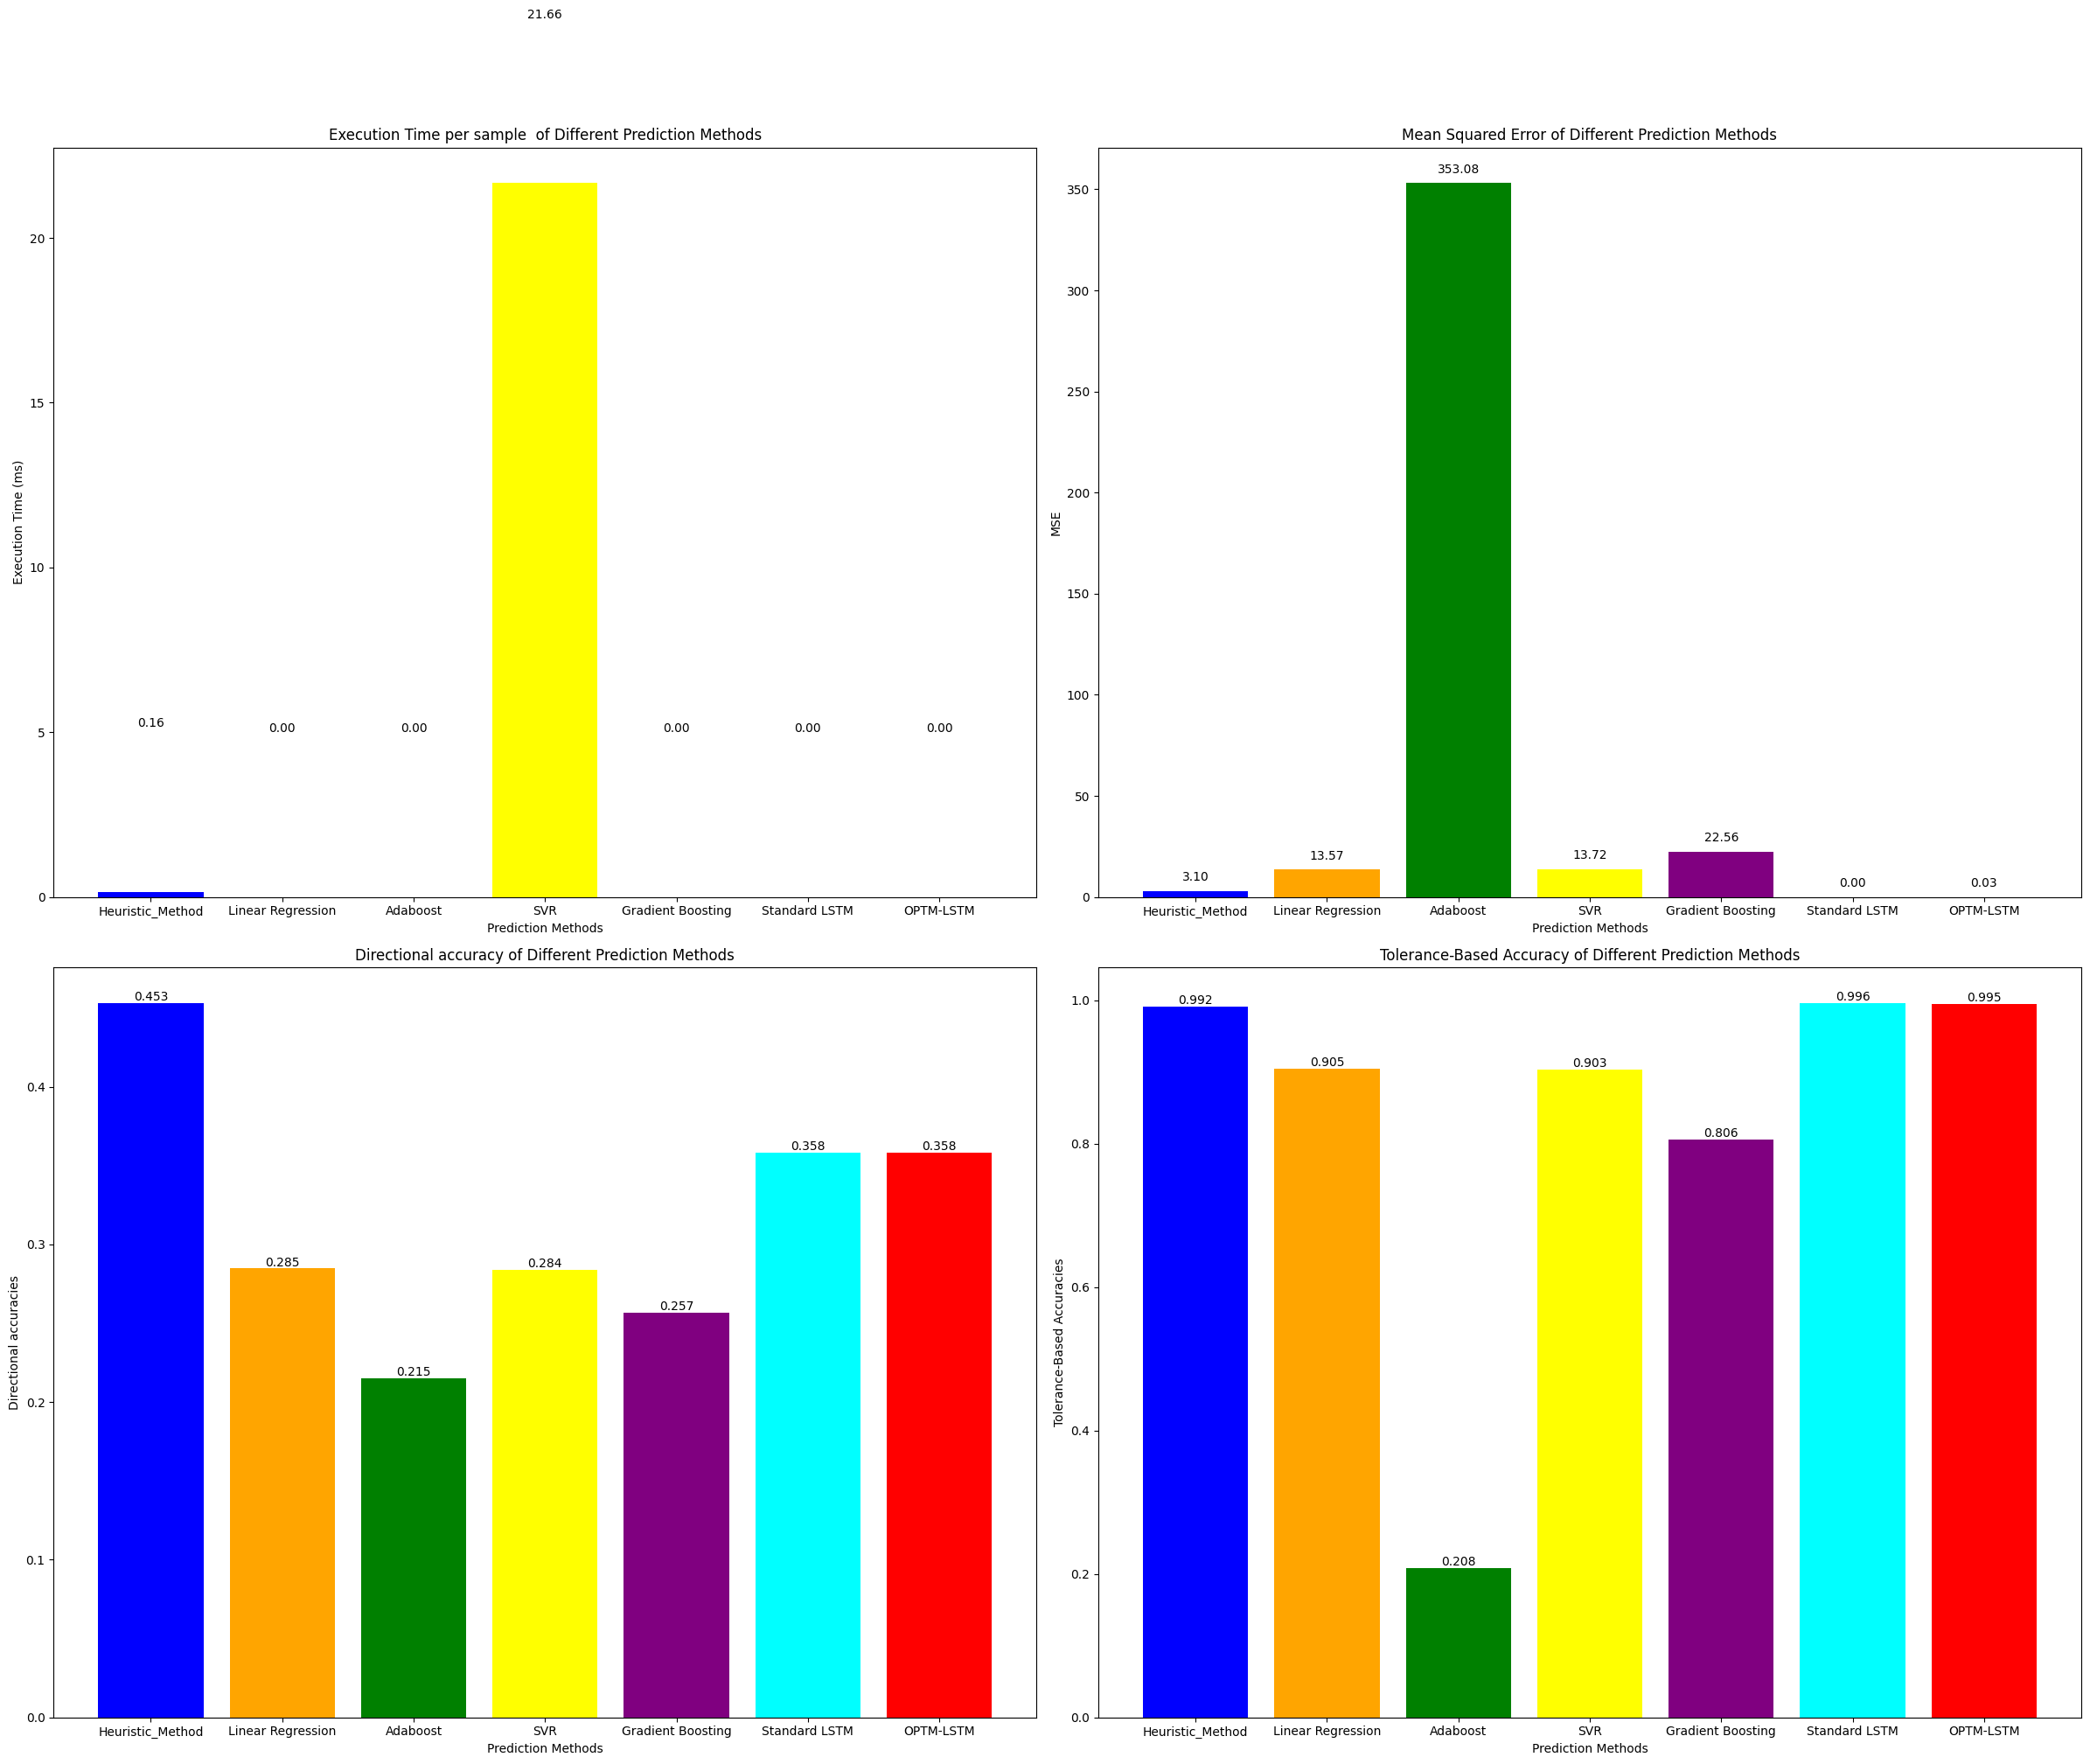

In [74]:


plt.figure(figsize=(24, 20))

# Create execution_times bar chart
plt.subplot(2,2,1)
plt.bar(methods, execution_times, color=['blue', 'orange', 'green','yellow','purple','cyan','red'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time per sample  of Different Prediction Methods')

# Display the value on top of the bars
for i, time in enumerate(execution_times):
    plt.text(i, time + 5, f"{time:.2f}", ha='center')

# Create mses bar chart
plt.subplot(2,2,2)
plt.bar(methods, mses, color=['blue', 'orange', 'green','yellow','purple','cyan','red'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('MSE')
plt.title('Mean Squared Error of Different Prediction Methods')

# Display the value on top of the bars
for i, mse in enumerate(mses):
    plt.text(i, mse + 5, f"{mse:.2f}", ha='center')

# Create directional_accuracies bar chart
plt.subplot(2,2,3)
directional_accuracies_bars=plt.bar(methods, directional_accuracies, color=['blue', 'orange', 'green','yellow','purple','cyan','red'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('Directional accuracies')
plt.title('Directional accuracy of Different Prediction Methods')

# Displaying the values on top of each bar
for bar in directional_accuracies_bars:
    height = bar.get_height()
    # plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    # Poster
    height_formatted = "{:.3g}".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2, height, height_formatted, ha='center', va='bottom')

# Create directional_accuracies bar chart
plt.subplot(2,2,4)
Tolerance_accuracies_bars=plt.bar(methods, Tolerance_accuracies, color=['blue', 'orange', 'green','yellow','purple','cyan','red'])

# Add labels and title
plt.xlabel('Prediction Methods')
plt.ylabel('Tolerance-Based Accuracies')
plt.title('Tolerance-Based Accuracy of Different Prediction Methods')

# Displaying the values on top of each bar
for bar in Tolerance_accuracies_bars:
    height = bar.get_height()
    # plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    # Poster
    height_formatted = "{:.3g}".format(height)
    plt.text(bar.get_x() + bar.get_width() / 2, height, height_formatted, ha='center', va='bottom')

# Show the charts
plt.tight_layout()
plt.show()

In [ ]:
# Performances=pd.DataFrame({"1st_mark_price_mse_lr": mse_lr[0],
#                                              "1st_mark_price_tolerance_accuracy_lr": tolerance_accuracy_lr[0],
#                                              "1st_mark_price_directional_accuracy_lr": directional_accuracy_lr[0],      
#                                              "1st_mark_price_mse_lr": mse_lr[1],
#                                              "1st_mark_price_tolerance_accuracy_lr": tolerance_accuracy_lr[1],
#                                              "1st_mark_price_directional_accuracy_lr": directional_accuracy_lr[1],
#                                              "execution_time":execution_time})

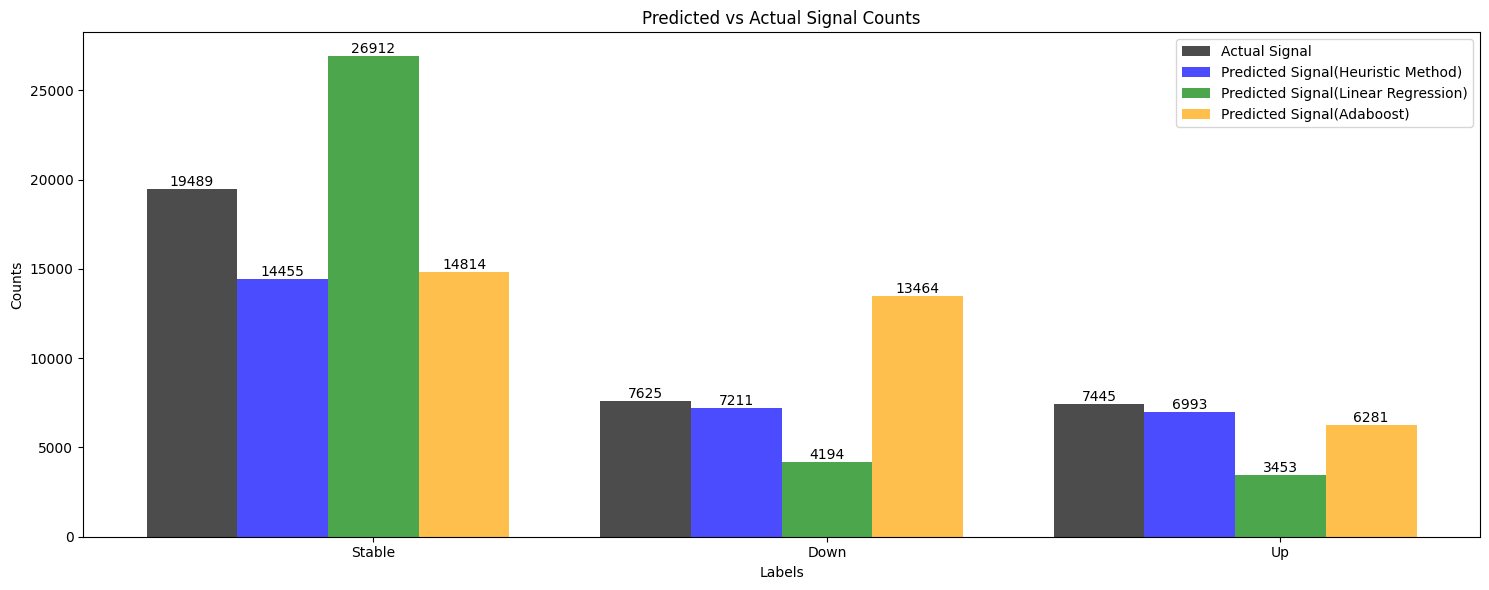

In [14]:
# # Add signal distribution visualization
# direction_mapping = {1.0: "up", 0.0: "stable", -1.0: "down"}
# Evaluate_result["predicted_movement_heuristic"] = Evaluate_result["predicted_direction_heuristic"].map(direction_mapping)

# # Add symbol columns based on comparison with the last mark price
# symbol_tolerance = 0.0001 * Evaluate_result["next_mark_price"].mean()  # Adjust as needed
# Evaluate_result.loc[:, "predicted_movement_lr"] = None
# Evaluate_result.loc[:, "predicted_movement_adaboost"] = None


# for i in range(len(Evaluate_result)):
#     # Linear Regression symbol logic
#     if Evaluate_result["predicted_lr"].iloc[i] > Evaluate_result["mark_price"].iloc[i] + symbol_tolerance:
#         Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_lr"] = "up"
#     elif Evaluate_result["predicted_lr"].iloc[i] < Evaluate_result["mark_price"].iloc[i] - symbol_tolerance:
#         Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_lr"] = "down"
#     else:
#         Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_lr"] = "stable"

#     # AdaBoost symbol logic
#     if Evaluate_result["predicted_adaboost"].iloc[i] > Evaluate_result["mark_price"].iloc[i]+ symbol_tolerance:
#         Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_adaboost"] = "up"
#     elif Evaluate_result["predicted_adaboost"].iloc[i] < Evaluate_result["mark_price"].iloc[i] - symbol_tolerance:
#         Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_adaboost"] = "down"
#     else:
#         Evaluate_result.loc[Evaluate_result.index[i], "predicted_movement_adaboost"] = "stable"

# Actual_signal_counts = Evaluate_result["Price Movement"].value_counts()
# symbol_counts_heuristic = Evaluate_result["predicted_movement_heuristic"].value_counts()
# symbol_counts_lr = Evaluate_result["predicted_movement_lr"].value_counts()
# symbol_counts_adaboost = Evaluate_result["predicted_movement_adaboost"].value_counts()

# labels = Actual_signal_counts.index.tolist()
# actual_values = Actual_signal_counts.values.tolist()

# heuristic_predict_values = symbol_counts_heuristic.values.tolist()
# lr_predict_values = symbol_counts_lr.values.tolist()
# adaboost_predict_values = symbol_counts_adaboost.values.tolist()

# # Setting the positions and width for the bars
# positions = np.arange(len(labels))
# bar_width = 0.2

# plt.figure(figsize=(15, 6))

# # Create the bar plot
# bar1=plt.bar(positions - 1.5*bar_width , actual_values, bar_width, label='Actual Signal', color='black', alpha=0.7)
# bar2=plt.bar(positions-0.5*bar_width, heuristic_predict_values, bar_width, label='Predicted Signal(Heuristic Method)', color='b', alpha=0.7)
# bar3=plt.bar(positions+ bar_width*0.5, lr_predict_values, bar_width, label='Predicted Signal(Linear Regression)', color='green', alpha=0.7)
# bar4=plt.bar(positions+ bar_width*1.5, adaboost_predict_values, bar_width, label='Predicted Signal(Adaboost)', color='orange', alpha=0.7)



# # Adding labels, title, and legend
# plt.xlabel('Labels')
# plt.ylabel('Counts')
# plt.title('Predicted vs Actual Signal Counts')
# plt.xticks(positions + bar_width / 2, labels)
# plt.legend()

# # Displaying the values on top of each bar
# for bar in bar1 + bar2 + bar3 + bar4:
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# plt.tight_layout()
# plt.show()